   IMDB dataset having 50K movie reviews for natural language processing or Text analysis.
   
   This is a dataset for binary sentiment classification. 
   
   So, we can predict the number of positive and negative reviews using classification algorithms.

## Table of contents

* [Part 1. Tokenization & stemming](#part1)

* [Part 2. Training & model building: Pipeline + TfidfVectorizer + GridSearchCV
(on stemmatized and tokenized data)](#part2)

* [Part 3. Training & model building: BERT](#part3)

* [Part 4. Conclusion](#part4)


### Tokenization & stemming <a class="anchor" id="part1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
from tqdm import notebook
import re
!pip install mglearn
import mglearn

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score

In [3]:
#import libraries for the bert model
!pip install torchvision
!pip install transformers
from tqdm import notebook
import torch, torchvision
import transformers as ppb # pytorch transformers

In [4]:
data=pd.read_csv('IMDB Dataset.csv')

In [5]:
data.head(5) 

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [8]:
data_copy=data.copy()

In [9]:
stop_words=nltk.corpus.stopwords.words('english') #loading stop words for English

In [10]:
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
string.punctuation #loading punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
dates = [str(x) for x in np.arange(1850, 2022)]  #loading dates

In [13]:
data['review'] = data['review'].str.lower() #bringing texts to lowercase

In [14]:
#the function for splitting texts into words
def tokenization(row):
    
    text = row['review']
    tokens = nltk.word_tokenize(text)   
    token_words = [word for word in tokens if (word not in string.punctuation 
                                              and word not in stop_words 
                                              and word not in dates
                                              and word.isalpha())]  
    return token_words

data['words'] = data.apply(tokenization, axis=1)

In [15]:
data.head()

,review,sentiment,words
0,one of the other reviewers has mentioned that ...,positive,"[one, reviewers, mentioned, watching, oz, epis..."
1,a wonderful little production. <br /><br />the...,positive,"[wonderful, little, production, br, br, filmin..."
2,i thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, thinks,..."
4,"petter mattei's ""love in the time of money"" is...",positive,"[petter, mattei, love, time, money, visually, ..."


In [16]:
stemmer = nltk.PorterStemmer()

In [17]:
#the function of bringing words to the base
def stemming(row):
    
    my_list = row['words']
    stemmed_words = [stemmer.stem(word) for word in my_list]
    
    return stemmed_words

data['stemmed_words'] = data.apply(stemming, axis=1)  

In [18]:
data.head()

,review,sentiment,words,stemmed_words
0,one of the other reviewers has mentioned that ...,positive,"[one, reviewers, mentioned, watching, oz, epis...","[one, review, mention, watch, oz, episod, hook..."
1,a wonderful little production. <br /><br />the...,positive,"[wonderful, little, production, br, br, filmin...","[wonder, littl, product, br, br, film, techniq..."
2,i thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe..."
3,basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, thinks,...","[basic, famili, littl, boy, jake, think, zombi..."
4,"petter mattei's ""love in the time of money"" is...",positive,"[petter, mattei, love, time, money, visually, ...","[petter, mattei, love, time, money, visual, st..."


In [19]:
#function for combining words back into texts
def rejoin_words(row):
    
    my_list = row['stemmed_words']
    joined_words = (" ".join(my_list))
    
    return joined_words

data['text'] = data.apply(rejoin_words, axis=1)

In [20]:
data = data[['text', 'sentiment']]

In [21]:
#replacing the format of the target variable
data['sentiment'] = data['sentiment'].replace({'positive' : 1, 'negative' : 0})

In [22]:
data.head()

,text,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product br br film techniqu fashi...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


Having finished with the data preprocessing, we can move on. Let's create 3 different classification models. We'll use the pipeline with the hyperparameter settings. Then we'll check the quality of the models on the test data.

### Training & model building: Pipeline + TfidfVectorizer + GridSearchCV (on stemmatized and tokenized data) <a class="anchor" id="part2"></a>

In [23]:
#splitting data into target variable and features
X = data['text']
y=data['sentiment']

In [24]:
##splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, data['sentiment'], test_size=0.25, random_state=12345)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37500,) (12500,) (37500,) (12500,)


In [25]:
#let's convert the texts to a readable format for python (unicode)
corpus = X_train.values.astype('U')
corpus_test = X_test.values.astype('U')

In [26]:
# count_tf_idf = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=0.1, 
#                                norm = None, ngram_range=(1, 2), max_features = 50)
# X_train_tfidf = count_tf_idf.fit_transform(corpus)

# print(tf_idf.shape)

#X_test_tfidf = count_tf_idf.transform(X_test)

In [27]:
%%time
#create the pipeline with tfidfvect. and log.reg.
pipe1 = Pipeline([
                  ('vect', TfidfVectorizer(stop_words='english', max_df = 0.75, min_df = 0.1, 
                                           norm = None, max_features = 50)),
                  ('log_reg', LogisticRegression(solver = 'liblinear', random_state=12345))
])

# Define the parameter grid to be used in GridSearch
param_grid = {
    'vect__ngram_range': ((1, 1), (1, 2)),
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__C': np.logspace(-4, 4, 20)
}

#define the gridsearch for pipe1
grid1=GridSearchCV(pipe1, param_grid, cv=5, scoring='f1', verbose =1, n_jobs = -1)
#training
grid1.fit(corpus, y_train)

print(grid1.best_score_)
print(grid1.best_params_)
print(grid1.best_estimator_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
0.7049233804705575
{'log_reg__C': 0.004832930238571752, 'log_reg__penalty': 'l2', 'vect__ngram_range': (1, 2)}
Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.75, max_features=50, min_df=0.1,
                                 ngram_range=(1, 2), norm=None,
                                 stop_words='english')),
                ('log_reg',
                 LogisticRegression(C=0.004832930238571752, random_state=12345,
                                    solver='liblinear'))])
Wall time: 23min 57s


In [28]:
%%time

pipe1.set_params(**grid1.best_params_)
pipe1.fit(corpus, y_train)
pred1=pipe1.predict(corpus_test)

f1_1 = f1_score(y_test, pred1)
f1_1

Wall time: 19.6 s


0.6980335960512698

Quality metric turned out to be quite good. We can see most important words below.

Text(0.5, 1.0, 'tfidf-cofficient')

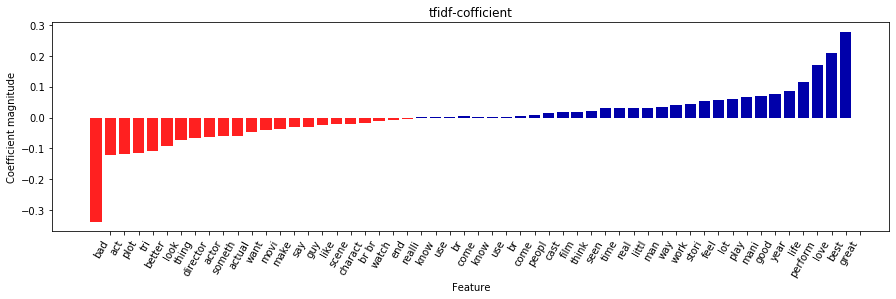

In [29]:
feature_names = np.array(grid1.best_estimator_.named_steps['vect'].get_feature_names())
coef = grid1.best_estimator_.named_steps['log_reg'].coef_
mglearn.tools.visualize_coefficients(coef,feature_names, n_top_features=27)
plt.title("tfidf-cofficient")

In [30]:
feature_names

array(['act', 'actor', 'actual', 'bad', 'best', 'better', 'br', 'br br',
       'cast', 'charact', 'come', 'director', 'end', 'feel', 'film',
       'good', 'great', 'guy', 'know', 'life', 'like', 'littl', 'look',
       'lot', 'love', 'make', 'man', 'mani', 'movi', 'peopl', 'perform',
       'play', 'plot', 'real', 'realli', 'say', 'scene', 'seen', 'someth',
       'stori', 'thing', 'think', 'time', 'tri', 'use', 'want', 'watch',
       'way', 'work', 'year'], dtype='<U8')

For negative review(red part), words such as “bad”, “act” appear. For positive review(blue part), words such as “great”, “best” appear. Strangely there are also word such as “better” in red which should have been in positive review.

In [31]:
%%time
#create the pipeline with tfidfvect. and model of one kind of naive bayes(ComplementNB)
pipe2 = Pipeline([
                  ('vect', TfidfVectorizer(stop_words='english', max_df = 0.75, min_df = 0.1, 
                                           norm = None, max_features = 50)),
                  ('compl_nb', ComplementNB())
])

# Define the parameter grid to be used in GridSearch
param_grid = {
    'vect__ngram_range': ((1, 1),(1, 2)),
    'compl_nb__alpha': [0, 0.01, 0.1, 0.5, 1.0, 10.0]
}

#define the gridsearch for pipe
grid2=GridSearchCV(pipe2, param_grid, cv=5, scoring='f1', verbose =1, n_jobs = -1)
#training
grid2.fit(corpus, y_train)

print(grid2.best_score_)
print(grid2.best_params_)
print(grid2.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.6963649731226503
{'compl_nb__alpha': 0, 'vect__ngram_range': (1, 2)}
Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.75, max_features=50, min_df=0.1,
                                 ngram_range=(1, 2), norm=None,
                                 stop_words='english')),
                ('compl_nb', ComplementNB(alpha=0))])
Wall time: 4min 30s


In [32]:
%%time
pipe2.set_params(**grid2.best_params_)
pipe2.fit(corpus, y_train)
pred2=pipe2.predict(corpus_test)

f1_2 = f1_score(y_test, pred2)
f1_2

Wall time: 19.9 s


0.69243670633336

In [33]:
feature_names

array(['act', 'actor', 'actual', 'bad', 'best', 'better', 'br', 'br br',
       'cast', 'charact', 'come', 'director', 'end', 'feel', 'film',
       'good', 'great', 'guy', 'know', 'life', 'like', 'littl', 'look',
       'lot', 'love', 'make', 'man', 'mani', 'movi', 'peopl', 'perform',
       'play', 'plot', 'real', 'realli', 'say', 'scene', 'seen', 'someth',
       'stori', 'thing', 'think', 'time', 'tri', 'use', 'want', 'watch',
       'way', 'work', 'year'], dtype='<U8')

In [34]:
%%time
#create the pipeline with tfidfvect. and model of one type of nearest neighbor methods (KNeighborsClassifier)
pipe3 = Pipeline([
                  ('vect', TfidfVectorizer(stop_words='english', max_df = 0.75, min_df = 0.1, 
                                           norm = None, max_features = 50)),
                  ('knc', KNeighborsClassifier())
])
k_range = list(range(1, 31, 2))
# Define the parameter grid to be used in GridSearch
param_grid = {
    'vect__ngram_range': ((1, 1),(1, 2)),
    'knc__n_neighbors': k_range
}

#define the gridsearch for pipe
grid3=GridSearchCV(pipe3, param_grid, cv=5, scoring='f1', verbose =1, n_jobs = -1)
#training
grid3.fit(corpus, y_train)

print(grid3.best_score_)
print(grid3.best_params_)
print(grid3.best_estimator_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0.6599938411793526
{'knc__n_neighbors': 29, 'vect__ngram_range': (1, 1)}
Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.75, max_features=50, min_df=0.1,
                                 norm=None, stop_words='english')),
                ('knc', KNeighborsClassifier(n_neighbors=29))])
Wall time: 22min 39s


In [35]:
%%time
pipe3.set_params(**grid3.best_params_)
pipe3.fit(corpus, y_train)
pred3=pipe3.predict(corpus_test)

f1_3 = f1_score(y_test, pred3)
f1_3

Wall time: 35.9 s


0.6555671175858481

Among the 3 models, the best quality of the f1 score turned out to be for the logistic regression model. On the training sample f1 is about 0.705, on the test data f1 score is about 0.698

Let's build a BERT model and compare the score with the previous ones

### Part 3. Training & model building: BERT <a class="anchor" id="part3"></a>

In [36]:
data_copy['sentiment'] = data_copy['sentiment'].replace({'positive': 1, 'negative': 0})

In [37]:
#let's leave 400 texts to speed up the process
batch_1 = data_copy[:400]
print(batch_1)

                                                review  sentiment
0    One of the other reviewers has mentioned that ...          1
1    A wonderful little production. <br /><br />The...          1
2    I thought this was a wonderful way to spend ti...          1
3    Basically there's a family where a little boy ...          0
4    Petter Mattei's "Love in the Time of Money" is...          1
..                                                 ...        ...
395  I commented on this when it first debuted and ...          0
396  Just because someone is under the age of 10 do...          0
397  "Hey Babu Riba" is a film about a young woman,...          1
398  After a snowstorm, the roads are blocked and t...          0
399  This movie was a fairly entertaining comedy ab...          1

[400 rows x 2 columns]


In [38]:
batch_1['sentiment'].value_counts()

0    210
1    190
Name: sentiment, dtype: int64

In [39]:
#loading the pre-trained model and tokenizer
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')


tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
#tokenization
tokenized = batch_1['review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))) 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [41]:
#fill in the received lists with the same size
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)


# applying padding to vectors       
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [42]:
np.array(padded).shape

(400, 512)

In [43]:
#we need to create another variable to tell BERT to ignore (mask) the padding we've added
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(400, 512)

In [44]:
#let's create an embeddings
batch_size = 20
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [45]:
#let's collect all embeddings into a feature matrix
features = np.concatenate(embeddings)

In [46]:
#splitting our datset into a training set and testing set
X_train, X_test, y_train, y_test = train_test_split(features, batch_1['sentiment'], test_size=0.25)

In [47]:
%%time
param_grid = {'C': np.linspace(0.0001, 100, 20)}

#define the gridsearch
grid4 = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', verbose =1, n_jobs = -1)
#training
grid4.fit(X_train, y_train)

print(grid4.best_score_)
print(grid4.best_params_)
print(grid4.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.8082566573974148
{'C': 5.263252631578947}
LogisticRegression(C=5.263252631578947)
Wall time: 5.44 s


In [48]:
%%time
lr = LogisticRegression()
lr.set_params(**grid4.best_params_)
lr.fit(X_train, y_train)

Wall time: 47.1 ms


LogisticRegression(C=5.263252631578947)

In [49]:
pred_train=lr.predict(X_train)

print(f1_score(y_train, pred_train))

1.0


In [50]:
pred_test = lr.predict(X_test)
f1_4 = f1_score(y_test, pred_test)
f1_4

0.7654320987654323

The quality metric for the BERT model turned out to be higher than for the first model (Logistic Regression)

In [51]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['LogisticRegression', 'ComplementNB',
                                           'KNeighborsClassifier', 'BERT'],
                                 'f1_score': [f1_1, f1_2, f1_3, f1_4]})

In [52]:
model_comparison = model_comparison.set_index('model')
print(model_comparison)

                      f1_score
model                         
LogisticRegression    0.698034
ComplementNB          0.692437
KNeighborsClassifier  0.655567
BERT                  0.765432


The best model is BERT, model's f1-measure is the highest(about 0.77).

### Conclusion <a class="anchor" id="part4"></a>

So, we prepared the data (lemmatized and stemmatized), trained 3 classification models (LogisticRegression, ComplementNB, KNeighborsClassifier) with hyperparameter tuning using Pipeline and TFidfVectorizer. We trained BERT model as well.

We chose f1_score as quality metrics.
The implementation of the Bert model turned out to be the best of all. f1 score for test data is about 0.77